In [274]:
import os
import tensorflow as tf
import pandas as pd
import numpy as np
import scipy
import PIL
import matplotlib.pyplot as plt

In [8]:
one_hot_output = pd.read_csv('Major_Background_one_hot.csv')

In [10]:
image_data = "C:\\Users\\arvra\\Documents\\UVa files\\Research Assistantship\\截图"
images = os.listdir(image_data)

In [59]:
image_numbers = [each.replace(".jpg","").replace(".png","").replace(".gif","") for each in images]
available_images = [each for each in image_numbers if each in one_hot_output.Index.values]

In [84]:
#available_images

#### To optimize the below code

In [263]:
from PIL import Image
file_names = [av_images for each in available_images for av_images in images if each in av_images]

d_avail = {}
for each in available_images:
    for im in images:
        if(each in im):
            d_avail[each] = im
    
size = 256
images_dict = {}
images_dict_new = {}
image_array = []
image_with_aspect = []
for each in d_avail.values():
    #images_dict[each] = np.array(Image.open())
    image = scipy.ndimage.imread(image_data+'\\'+each, mode="RGB")
    image_resized = scipy.misc.imresize(image, (256, 256))
    image_resized_255 = (image_resized/255).astype('float32')
    image_array.append(image_resized_255)
    
## MAINTAINING THE ASPECT RATIO    
#     img = Image.open(image_data+'\\'+each)
#     wpercent = (size/float(img.size[0]))
#     hsize = int((float(img.size[1])*float(wpercent)))
#     img = img.resize((size,hsize), PIL.Image.ANTIALIAS)
#     image_with_aspect.append(img)

C:\Users\arvra\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  
C:\Users\arvra\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
C:\Users\arvra\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
C:\Users\arvra\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


#### Preprocessing to be done to change the square images to square and maintain the aspect ratio of others

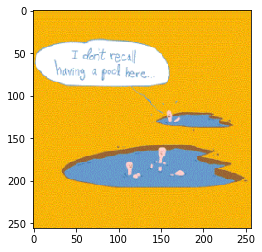

In [267]:
n = 10
plt.imshow(image_array[n])
plt.show()

In [268]:
sum(one_hot_output.Index.isin(available_images))

765

In [269]:
df = one_hot_output[one_hot_output.Index.isin(available_images)].sort_values('Index')
df['available_images'] = available_images

In [270]:
df[~(df.Index == df.available_images)].shape[0]

0

#### Number of input images and Y vector do not match

In [271]:
X_train = np.asarray(image_array) 
Y_train = np.array(df.iloc[:,1:df.shape[1]-1])

print ("number of training examples = " + str(X_train.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
conv_layers = {}

number of training examples = 765
X_train shape: (765, 256, 256, 3)
Y_train shape: (765, 14)


#### 1.1 - Create placeholders

TensorFlow requires that you create placeholders for the input data that will be fed into the model when running the session.

**Exercise**: Implement the function below to create placeholders for the input image X and the output Y. You should not define the number of training examples for the moment. To do so, you could use "None" as the batch size, it will give you the flexibility to choose it later. Hence X should be of dimension **[None, n_H0, n_W0, n_C0]** and Y should be of dimension **[None, n_y]**.  [Hint](https://www.tensorflow.org/api_docs/python/tf/placeholder).

In [307]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_H0 -- scalar, height of an input image
    n_W0 -- scalar, width of an input image
    n_C0 -- scalar, number of channels of the input
    n_y -- scalar, number of classes
        
    Returns:
    X -- placeholder for the data input, of shape [None, n_H0, n_W0, n_C0] and dtype "float"
    Y -- placeholder for the input labels, of shape [None, n_y] and dtype "float"
    """

    X = tf.placeholder(dtype = tf.float32, shape =[None, n_H0, n_W0, n_C0])
    Y = tf.placeholder(dtype = tf.float32, shape = [None, n_y])
    
    return X, Y

#### 1.2 - Initialize parameters

You will initialize weights/filters $W1$ and $W2$ using `tf.contrib.layers.xavier_initializer(seed = 0)`. You don't need to worry about bias variables as you will soon see that TensorFlow functions take care of the bias. Note also that you will only initialize the weights/filters for the conv2d functions. TensorFlow initializes the layers for the fully connected part automatically. We will talk more about that later in this assignment.

Implement initialize_parameters(). The dimensions for each group of filters are provided below. Reminder - to initialize a parameter $W$ of shape [1,2,3,4] in Tensorflow, use:
```python
W = tf.get_variable("W", [1,2,3,4], initializer = ...)
```


In [308]:
# GRADED FUNCTION: initialize_parameters

def initialize_parameters():
    """
    Initializes weight parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [4, 4, 3, 8]
                        W2 : [2, 2, 8, 16]
    Returns:
    parameters -- a dictionary of tensors containing W1, W2
    """
    
    tf.set_random_seed(1)                              # so that your "random" numbers match ours
        
    init = tf.contrib.layers.xavier_initializer(seed = 0)
    W1 = tf.get_variable("W1",shape = [4, 4, 3, 8], initializer=  init)
    W2 = tf.get_variable("W2",shape = [2, 2, 8, 16], initializer=  init)
  
    parameters = {"W1": W1,
                  "W2": W2}
    
    return parameters

#### Forward Propogation

In [309]:
# GRADED FUNCTION: forward_propagation

def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "W2"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    ### START CODE HERE ###
    # CONV2D: stride of 1, padding 'SAME'
    Z1 = tf.nn.conv2d(X,W1,[1,1,1,1],padding="SAME")
    # RELU
    A1 = tf.nn.relu(Z1)
    # MAXPOOL: window 8x8, sride 8, padding 'SAME'
    P1 = tf.nn.max_pool(A1,ksize = [1,8,8,1],strides = [1,8,8,1],padding = 'SAME')
    # CONV2D: filters W2, stride 1, padding 'SAME'
    Z2 = tf.nn.conv2d(P1,W2,[1,1,1,1], padding='SAME')
    # RELU
    A2 = tf.nn.relu(Z2)
    # MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P2 = tf.nn.max_pool(A2,ksize = [1,4,4,1], strides= [1,4,4,1], padding ='SAME')
    # FLATTEN
    P2 = tf.contrib.layers.flatten(P2)
    # FULLY-CONNECTED without non-linear activation function (not not call softmax).
    # 6 neurons in output layer. Hint: one of the arguments should be "activation_fn=None" 
    Z3 = tf.contrib.layers.fully_connected(P2,14,activation_fn=None)
    ### END CODE HERE ###

    return Z3

#### Cost Function

In [311]:
# GRADED FUNCTION: compute_cost 

def compute_cost(Z3, Y):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    ### START CODE HERE ### (1 line of code)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Z3, labels = Y),axis = 0)
    ### END CODE HERE ###
    
    return cost

### CNN Model

In [312]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples) (m, Hi, Wi, Ci)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples) (m, n_y)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[0]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:,:,:]
    shuffled_Y = Y[permutation,:]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:,:,:]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m,:,:,:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [320]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.09,
          num_epochs = 5, minibatch_size = 32, print_cost = True):
    """
    Implements a three-layer ConvNet in Tensorflow:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    X_train -- training set, of shape (None, 64, 64, 3)
    Y_train -- test set, of shape (None, n_y = 6)
    X_test -- training set, of shape (None, 64, 64, 3)
    Y_test -- test set, of shape (None, n_y = 6)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    train_accuracy -- real number, accuracy on the train set (X_train)
    test_accuracy -- real number, testing accuracy on the test set (X_test)
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    tf.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep results consistent (tensorflow seed)
    seed = 3                                          # to keep results consistent (numpy seed)
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of the correct shape
    ### START CODE HERE ### (1 line)
    X, Y = create_placeholders(n_H0, n_W0, n_C0,n_y)
    ### END CODE HERE ###

    # Initialize parameters
    ### START CODE HERE ### (1 line)
    parameters = initialize_parameters() 
    ### END CODE HERE ###
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    ### START CODE HERE ### (1 line)
    Z3 = forward_propagation(X, parameters)
    ### END CODE HERE ###
    
    # Cost function: Add cost function to tensorflow graph
    ### START CODE HERE ### (1 line)
    cost = compute_cost(Z3, Y)
    ### END CODE HERE ###
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer that minimizes the cost.
    ### START CODE HERE ### (1 line)
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    ### END CODE HERE ###
    
    # Initialize all the variables globally
    init = tf.global_variables_initializer()
     
    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the optimizer and the cost, the feedict should contain a minibatch for (X,Y).
                ### START CODE HERE ### (1 line)
                _ , temp_cost = sess.run([optimizer,cost], {X: minibatch_X, Y: minibatch_Y})
                ### END CODE HERE ###
                
                minibatch_cost += temp_cost / num_minibatches
                

            # Print the cost every epoch
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
        
        
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Calculate the correct predictions
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
                
        return train_accuracy, test_accuracy, parameters

Cost after epoch 0: 10.222463
Cost after epoch 0: 10.222463
Cost after epoch 1: 2.538822
Cost after epoch 2: 2.507400
Cost after epoch 3: 2.503812
Cost after epoch 4: 2.502240


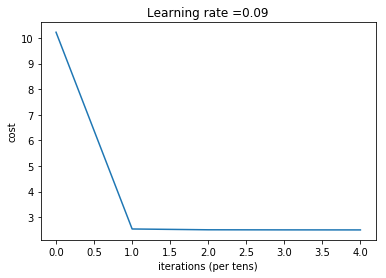

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.23006536
Test Accuracy: 0.23006536


In [321]:
_, _, parameters = model(X_train, Y_train, X_train, Y_train)